In [1]:
import numpy as np
import scipy as sp
from scipy import optimize
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def dilser(low=0.001, limit=100., dilfactor=2.):
    '''returns a numpy array dilution series from low to limit'''
    #replace this with a generator/iterator someday
    a = [low]
    while a[-1] <= limit:
        a.append(a[len(a)-1]*dilfactor)
    return np.array(a)

In [59]:
def binterval(k):
    '''takes apparent binding constent and builds lig series around it (2 log intervals on either end)'''
    low = (1/k)/1000
    limit = (1/k)*100
    return dilser(low=low,limit=limit)

In [60]:
def lognuniform(low=0, high=1, size=None, base=np.exp(1)):
    return np.power(base, np.random.uniform(low, high, size))

In [61]:
def guessgen(length,lowmag=-3,himag=3,base=10):
    return tuple(lognuniform(low=lowmag,high=himag,base=base) for i in range(length))

In [62]:
def colroots(data,ligs): 
    holder = []
    for i in range(len(ligs)):
        temp = data[:,i]
        roots,counts = np.unique(temp,return_counts=True)
        posroots = roots[roots>0]
        poscounts = counts[roots>0]
        clctd = np.stack((posroots,poscounts),axis=1)
        clctd = clctd[(-1*clctd[:,1]).argsort()]
        holder.append(clctd[:3]) #only take top 3 (or fewer) guesses
    return holder

In [63]:
def wymsol(var,parm,rtot,ltot):
    
    k11 = parm[0]
    k21 = parm[1]
    k22 = parm[2]
    l20 = parm[3]
    
    (L, M, MM, ML, MML, MMLL) = var
    
    eq1 = (M + 2*MM + ML + 2*MML + 2*MMLL) - rtot
    eq2 = (L + ML + MML + 2*MMLL) - ltot
    eq3 = (l20 * M*M) - MM
    eq4 = (k11 * L * M) - ML
    eq5 = (l20 * k21 * M*M * L) - MML
    eq6 = (k22 * L * MML) - MMLL
    
    return np.array([eq1,eq2,eq3,eq4,eq5,eq6])

In [64]:
def wym_obj(guess,model,data,ligs,rtot):
    datac = np.concatenate(data)
    return (model(guess,ligs,rtot)-datac)

def fit_wym(guess,model,data,ligs,rtot,bnds,loss='linear'):
        return sp.optimize.least_squares(wym_obj,guess,args=(model,data,ligs,rtot),bounds=bnds,method='trf',ftol=1e-14,gtol=1e-14,xtol=1e-14,loss=loss)

In [65]:
def wymfunc(parm,lig,rtot):
    '''
    Model function for dimerizing, single-site receptors as derived in
    (Wyman and Gill, Binding and Linkage, 1990) and used by
    (Macdonald and Pike, ...EGF-binding...negative cooperativity...aggregating system, 2008).
    Takes numpy array of parameters [k11,k21,k22,l20], numpy array of free ligand concentrations,
    and total receptor concentration. Returns the fraction of receptor bound to ligand.

    To generate a data set, iterate over an array of desired receptor concentrations, e.g.:
    [wymfunc(parm,lig,i) for i in array_of_rtots]

    For use in curve fitting an objective function for use with scipy.optimize.least_squares
    is readily constructed as: (wymfun(parm_guess,lig,rtot) - actual_data)
    '''

    #ensure dimension/broadcasting compatibility of inputs
    if ((rtot.ndim > 0) and (rtot.ndim != lig.ndim)):
        rtot = rtot[:,None] #adds dimension so that it can be broadcast
    else:
        rtot = rtot

    #unpack parameters
    k11 = parm[0]
    k21 = parm[1]
    k22 = parm[2]
    l20 = parm[3]

    ### START MODEL FUNCTION ###

    #calculate concentration of free (unoccupied) receptor
    rfree = (((-1 - k11*lig)) + \
    ((np.square((1 + k11*lig)) + \
    8.*l20*rtot*(1 + k21*lig + k21*k22*(np.square(lig)))))**0.5) \
    / (4*l20*(1 + k21*lig + k21*k22*(np.square(lig))))

    #calculate bound fraction
    bfrac = (k11*lig + l20*k21*rfree*lig + \
    2*l20*k21*k22*rfree*(np.square(lig))) \
    / (1 + 2*l20*rfree + k11*lig + \
    2*l20*k21*rfree*lig + 2*l20*k21*k22*rfree*(np.square(lig)))

    ### END MODEL FUNCTION ###

    #flatten output
    if ((rtot.ndim > 0) and (rtot.ndim != lig.ndim)):
        return bfrac.flatten()
    elif (rtot.ndim == 0):
        return bfrac.flatten()
    else:
        return np.concatenate(bfrac)

In [66]:
def wymfunc_fix(parm,lig,rtot):
    '''
    Model function for dimerizing, single-site receptors as derived in
    (Wyman and Gill, Binding and Linkage, 1990) and used by
    (Macdonald and Pike, ...EGF-binding...negative cooperativity...aggregating system, 2008).
    Takes numpy array of parameters [k11,k21,k22,l20], numpy array of free ligand concentrations,
    and total receptor concentration. Returns the fraction of receptor bound to ligand.

    To generate a data set, iterate over an array of desired receptor concentrations, e.g.:
    [wymfunc(parm,lig,i) for i in array_of_rtots]

    For use in curve fitting an objective function for use with scipy.optimize.least_squares
    is readily constructed as: (wymfun(parm_guess,lig,rtot) - actual_data)
    '''

    #ensure dimension/broadcasting compatibility of inputs
    if ((rtot.ndim > 0) and (rtot.ndim != lig.ndim)):
        rtot = rtot[:,None] #adds dimension so that it can be broadcast
    else:
        rtot = rtot

    #unpack parameters
    k11 = parm[0]
    k21 = parm[1]
    k22 = k21/4.
    l20 = parm[2]

    ### START MODEL FUNCTION ###

    #calculate concentration of free (unoccupied) receptor
    rfree = (((-1 - k11*lig)) + \
    ((np.square((1 + k11*lig)) + \
    8.*l20*rtot*(1 + k21*lig + k21*k22*(np.square(lig)))))**0.5) \
    / (4*l20*(1 + k21*lig + k21*k22*(np.square(lig))))

    #calculate bound fraction
    bfrac = (k11*lig + l20*k21*rfree*lig + \
    2*l20*k21*k22*rfree*(np.square(lig))) \
    / (1 + 2*l20*rfree + k11*lig + \
    2*l20*k21*rfree*lig + 2*l20*k21*k22*rfree*(np.square(lig)))

    ### END MODEL FUNCTION ###

    #flatten output
    if ((rtot.ndim > 0) and (rtot.ndim != lig.ndim)):
        return bfrac.flatten()
    elif (rtot.ndim == 0):
        return bfrac.flatten()
    else:
        return np.concatenate(bfrac)

In [67]:
rtotwym = np.array([1e-5,1e-4,1e-3,1e-2,1e-1])
parmwym = np.array([10.,10.,.01,500.])
wymguesses = [guessgen(6) for i in range(50)]

In [12]:
lig_concs = binterval(10)

In [13]:
%%time
wymar = np.array([[[optimize.root(wymsol,i,args=(parmwym,q,j),method='lm',options={'ftol':1e-14,'gtol':1e-14,'xtol':1e-14}).x for j in lig_concs] for i in wymguesses] for q in rtotwym])

CPU times: user 10.3 s, sys: 46.9 ms, total: 10.4 s
Wall time: 10.6 s


In [14]:
#original 
rootbag_wym = [[colroots(wymar[k,:,:,j],lig_concs) for j in range(6)] for  k in range(5)]

In [15]:
allroots = np.array([[np.array([rootbag_wym[q][j][i][0][0] for i in range(len(lig_concs))]) for j in range(6)] for q in range(5)])

In [16]:
data = np.array([(allroots[i][3] + allroots[i][4] + 2*allroots[i][5])/rtotwym[i] for i in range(5)])
ligs = np.array([allroots[i][0] for i in range(5)])
rtot = np.array([rtotwym[i] for i in range(5)])
guess = np.array([10.,10.,10.,10.])

In [56]:

rtot >1/ parmwym[3] 

array([False, False, False,  True,  True], dtype=bool)

In [58]:
parmwym[1]/parmwym[2] > 4

True

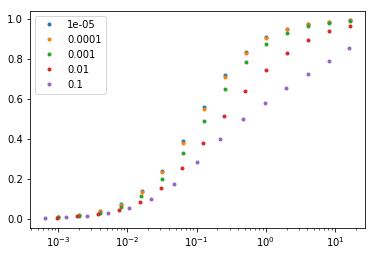

In [51]:
for i in range(ligs.shape[0]):
    plt.semilogx(ligs[i],data[i],'.')
plt.legend([str(i) for i in rtot])

In [18]:
lsbnds = (tuple(1e-4 for i in range(4)),tuple(1e4 for i in range(4)))
lsbnds_fix = (tuple(1e-4 for i in range(3)),tuple(1e4 for i in range(3)))

In [19]:
fit = fit_wym(guess,wymfunc,data,ligs,rtot,lsbnds)

In [20]:
fit.x

array([  1.00000000e+01,   1.00000000e+01,   1.00000000e-02,
         5.00000000e+02])

In [21]:
ndata = data + np.random.normal(loc=0,scale=0.02,size=(data.shape))

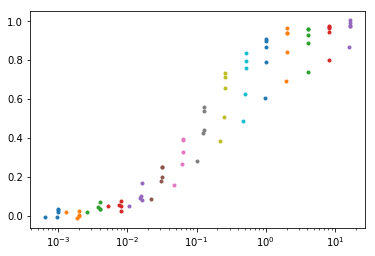

In [22]:
plt.semilogx(ligs,ndata,'.');

In [152]:
nfit = fit_wym(guess,wymfunc,ndata,ligs,rtot,lsbnds)

In [153]:
nfit.x

array([  2.11603849e+00,   1.97149342e+00,   4.73296761e-01,
         5.84714507e+02])

In [79]:
computes = np.array([wymfunc(parmwym,lig_concs,i) for i in rtotwym])

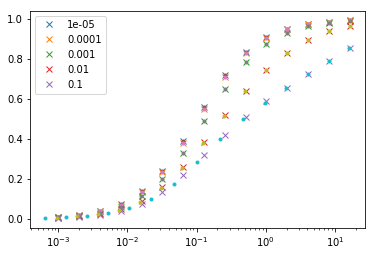

In [77]:
for i in computes:
    plt.semilogx(lig_concs,i,'x')
    
for i in range(ligs.shape[0]):
    plt.semilogx(ligs[i],data[i],'.')
plt.legend([str(i) for i in rtot])

In [89]:
bundr = rtotwym.reshape(-1,1) * computes

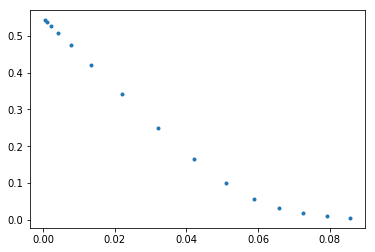

In [95]:
f = 4
plt.plot(bundr[f],(bundr[f]/lig_concs),'.')